<a href="https://colab.research.google.com/github/w95wayne10/MLLab/blob/main/TPU_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code copy from [here](https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/getting-started.ipynb#scrollTo=8WTsdQ3yO-8G) and [here](https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/single-core-alexnet-fashion-mnist.ipynb).

In [ ]:
#!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

In [17]:
# Downloads the Fashion MNIST dataset using Torchvision
# Note: This may take a minute.
import os
import torch
import torchvision
import torchvision.datasets as datasets

In [2]:
# Maps integer class index to human-readable string describing the class
class_map = {
0 : "t-shirt",
1 : "trouser",
2 : "pullover",
3 : "dress",
4 : "coat",
5 : "sandal",
6 : "shirt",
7 : "sneaker",
8 : "bag",
9 : "ankle boot"
}

In [3]:
# Downloads the Fashion MNIST dataset using Torchvision
raw_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



In [5]:
raw_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

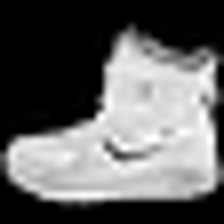

ankle boot


In [6]:
img_index = 0
tup = raw_dataset[img_index]
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

In [9]:
raw_dataset.classes[tup[1]]

'Ankle boot'

In [12]:
import torch_xla
import torch_xla.core.xla_model as xm

In [14]:
# Creates AlexNet for 10 classes
net = torchvision.models.alexnet(num_classes=10)

# Acquires the default Cloud TPU core and moves the model to it
device = xm.xla_device()
net = net.to(device)

In [15]:
import torchvision.transforms as transforms

# See https://pytorch.org/docs/stable/torchvision/models.html for normalization
# Pre-trained TorchVision models expect RGB (3 x H x W) images
# H and W should be >= 224
# Loaded into [0, 1] and normalized as follows:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
resize = transforms.Resize((224, 224))
my_transform = transforms.Compose([resize, to_rgb, transforms.ToTensor(), normalize])

In [16]:
train_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True,
  transform=my_transform)

test_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=False,
  download=True,
  transform=my_transform)

In [18]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
test_sampler = torch.utils.data.RandomSampler(test_dataset)

In [19]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size,
  sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size,
  sampler=test_sampler)

In [20]:
import time
from google.colab import widgets

t_to_img = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale()])

# Runs the given net on the batches provided by the test_loader
# Records the number of correct predictions (guesses) and 
# prints the percentage of correct guesses on the dataset, plus a 
# sample batch.
def eval_network(net, test_loader):
  start_time = time.time()
  num_correct = 0
  total_guesses = 0

  # Sets eval and no grad context for evaluation
  net.eval()
  with torch.no_grad():
    for data, targets in iter(test_loader):
      # Sends data and targets to device
      data = data.to(device)
      targets = targets.to(device)

      # Acquires the network's best guesses at each class
      results = net(data)
      best_guesses = torch.argmax(results, 1)

      # Updates number of correct and total guesses
      num_correct += torch.eq(targets, best_guesses).sum().item()
      total_guesses += batch_size
    
    # Prints output
    elapsed_time = time.time() - start_time
    print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")
    print("Evaluated in ", elapsed_time, " seconds")
    print("Sample batch:")
    
    # Uses last batch as sample
    grid = widgets.Grid(2, 4)
    row = 0
    col = 0
    for ex in zip(data, targets, best_guesses):
      data = ex[0].cpu()
      target = class_map[ex[1].item()]
      guess = class_map[ex[2].item()]

      img = t_to_img(data)

      with grid.output_to(row, col):
        display(img)
        print("Target: ", target)
        print("Guess: ", guess)

        # Updates grid location
        if col == 3:
          row += 1
          col = 0
        else:
          col += 1

Correctly guessed  9.35 % of the dataset
Evaluated in  97.23693585395813  seconds
Sample batch:


,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

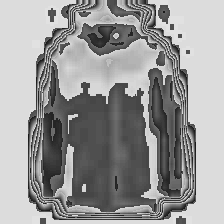

Target:  coat
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

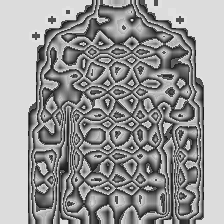

Target:  shirt
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

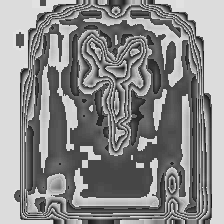

Target:  pullover
Guess:  shirt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

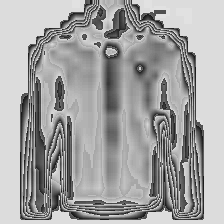

Target:  coat
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

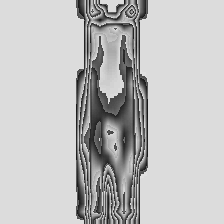

Target:  trouser
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

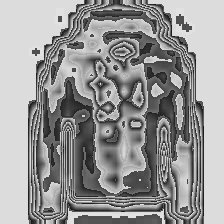

Target:  coat
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

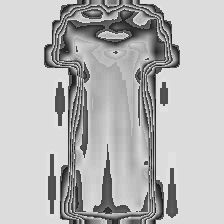

Target:  dress
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

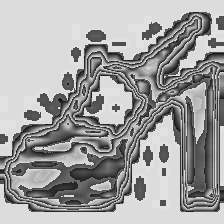

Target:  sandal
Guess:  bag


<IPython.core.display.Javascript object>

In [21]:
# Percentage of guesses that are correct (expected to be 0.1)
eval_network(net, test_loader)

In [22]:
# Note: this will take 5-10 minutes to run.
num_epochs = 1
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

# Ensures network is in train mode
net.train()

start_time = time.time()
for epoch in range(num_epochs):
  for data, targets in iter(train_loader):
    # Sends data and targets to device
    data = data.to(device)
    targets = targets.to(device)

    # Acquires the network's best guesses at each class
    results = net(data)

    # Computes loss
    loss = loss_fn(results, targets)

    # Updates model
    optimizer.zero_grad()
    loss.backward()
    xm.optimizer_step(optimizer, barrier=True)  # Note: Cloud TPU-specific code!

elapsed_time = time.time() - start_time
print ("Spent ", elapsed_time, " seconds training for ", num_epochs, " epoch(s) on a single core.")

Spent  588.602166891098  seconds training for  1  epoch(s) on a single core.


Correctly guessed  81.27 % of the dataset
Evaluated in  95.26354336738586  seconds
Sample batch:


,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

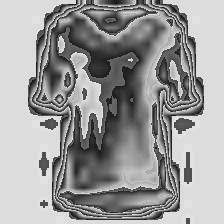

Target:  t-shirt
Guess:  t-shirt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

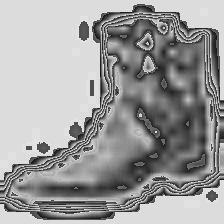

Target:  ankle boot
Guess:  ankle boot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

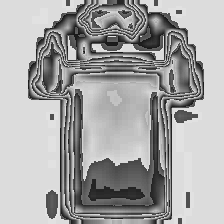

Target:  t-shirt
Guess:  t-shirt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

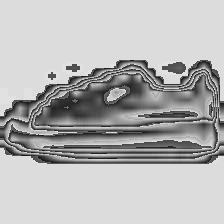

Target:  sneaker
Guess:  sneaker


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

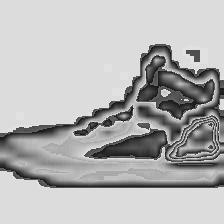

Target:  sneaker
Guess:  sandal


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

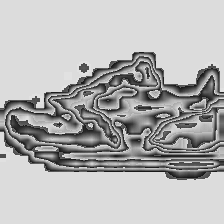

Target:  sneaker
Guess:  sneaker


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

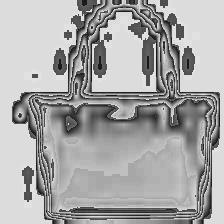

Target:  bag
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

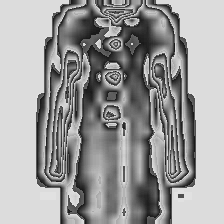

Target:  coat
Guess:  dress


<IPython.core.display.Javascript object>

In [23]:
eval_network(net, test_loader)

In [ ]:
import os 
assert os.environ["COLAB_TPU_ADDR"]

In [ ]:
#!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

In [ ]:
# imports pytorch
import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

In [ ]:
# Creates a random tensor on xla:1 (a Cloud TPU core)
dev = xm.xla_device()
t1 = torch.ones(3, 3, device = dev)
print(t1)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='xla:1')


In [ ]:
# Creating a tensor on the second Cloud TPU core
second_dev = xm.xla_device(n=2, devkind='TPU')
t2 = torch.zeros(3, 3, device = second_dev)
print(t2)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='xla:2')


In [ ]:
# Creates a tensor on the CPU (device='cpu' is unnecessary and only added for clarity)
t_cpu = torch.randn(2, 2, device='cpu')
print(t_cpu)

t_tpu = t_cpu.to(dev)
print(t_tpu)

t_cpu_again = t_tpu.to('cpu')
print(t_cpu_again)

tensor([[ 1.4045,  0.7363],
        [ 1.1352, -1.5485]])
tensor([[ 1.4045,  0.7363],
        [ 1.1352, -1.5485]], device='xla:1')
tensor([[ 1.4045,  0.7363],
        [ 1.1352, -1.5485]])


In [ ]:
# Creates a linear module
fc = torch.nn.Linear(5, 2, bias=True)

# Copies the module to the XLA device (the first Cloud TPU core)
fc = fc.to(dev)

# Creates a random feature tensor
features = torch.randn(3, 5, device=dev, requires_grad=True)

# Runs and prints the module
output = fc(features)
print(output)

tensor([[ 0.8637,  0.1248],
        [ 0.0615, -0.0756],
        [ 0.0207,  0.2022]], device='xla:1', grad_fn=<AddmmBackward0>)


In [ ]:
output.backward(torch.ones_like(output))
print(fc.weight.grad)

tensor([[-2.9727, -0.5938, -1.6533, -1.3672,  1.3125],
        [-2.9727, -0.5938, -1.6533, -1.3672,  1.3125]], device='xla:1')


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Simple example network from 
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# Places network on the default TPU core
net = Net().to(dev)

# Creates random input on the default TPU core
input = torch.randn(1, 1, 32, 32, device=dev)

# Runs network
out = net(input)
print(out)

tensor([[ 0.0910,  0.0952, -0.0135, -0.1657,  0.1122,  0.0136, -0.0356, -0.0137,
         -0.0522,  0.0480]], device='xla:1', grad_fn=<AddmmBackward0>)
